# Introduction to SOM in R
This is an introduction to SOM. Original example courtesy of Shane Lynn.

https://www.shanelynn.ie/self-organising-maps-for-customer-segmentation-using-r/

https://github.com/shanealynn/Kohonen-Self-organising-maps-in-R/

https://github.com/opetchey/RREEBES/wiki/Reading-data-and-code-from-an-online-github-repository

In [23]:
.libPaths()

[1] "C:/Users/ville_000/Documents/R/win-library/3.4"         
[2] "C:/Users/ville_000/Anaconda3/envs/mro_env/lib/R/library"

In [24]:
# Example for downloading a package
#install.packages('rgdal', repos='http://cran.us.r-project.org')

In [25]:
require(kohonen)
#require(RCurl)
require(rgeos)
require(rgdal)

In [26]:
# Load data
data_raw = read.csv("./census_data/AllThemesTablesSA.csv")
data_raw_safe = data_raw
head(data_raw)

# Join map data
ireland_map = readOGR('./boundary_files/Census2011_Small_Areas_generalised20m.shp', encoding = 'utf8')
#Note that the map polygons and the census data are not in the same order - rearrangement:
data_raw = data_raw[match(ireland_map$SMALL_AREA, data_raw$GEOGDESC),]
idcol="GEOGDESC"

# Filter for Dublin areas
counties = c("Fingal", "Dublin City", "South Dublin", "Dn Laoghaire-Rathdown")
plot_idx = ireland_map$COUNTYNAME %in% counties
data_raw = data_raw[plot_idx,]
ireland_map = ireland_map[plot_idx,]


ï..GEOGID,GEOGTYPE,GEOGDESC,T1_1AGE0M,T1_1AGE1M,T1_1AGE2M,T1_1AGE3M,T1_1AGE4M,T1_1AGE5M,T1_1AGE6M,...,T15_1_GE4C,T15_2_Y,T15_2_N,T15_2_NS,T15_2_T,T15_3_B,T15_3_OTH,T15_3_N,T15_3_NS,T15_3_T
A017001001,SA,017001001,6,5,6,5,4,2,4,...,5,93,28,2,123,70,22,30,1,123
A017002001,SA,017002001,2,2,3,2,3,5,2,...,4,83,24,1,108,64,19,25,0,108
A017002002,SA,017002002,3,2,0,1,2,2,7,...,3,109,23,3,135,93,14,24,4,135
A017002003,SA,017002003,1,0,1,2,1,0,0,...,8,86,16,2,104,77,10,15,2,104
A017003001,SA,017003001,1,2,4,3,0,2,2,...,3,57,20,1,78,41,8,26,3,78
A017003002,SA,017003002,1,2,2,1,3,4,2,...,5,80,28,0,108,66,11,30,1,108


OGR data source with driver: ESRI Shapefile 
Source: "D:\Dropbox\Data_Science_Projects\kdd\SOM_in_R\boundary_files\Census2011_Small_Areas_generalised20m.shp", layer: "Census2011_Small_Areas_generalised20m"
with 18488 features
It has 21 fields


## Data preprocessing

In [27]:
#convert the data from summations to percentages such 
#that the characteristics of each area will be comparable.
source("convertCSOdata.R")
data = convertCSOdata(data_raw, idcol=idcol)

incompletes = which(!complete.cases(data))
data$avr_education_level[incompletes] <- mean(data$avr_education_level, na.rm=TRUE)
#recalculate after adjustment
incompletes <- which(!complete.cases(data))
if (length(incompletes) > 0){
  print(paste0("Removing ", length(incompletes), " data points that have missing values."))
  data <- data[-incompletes, ]
}

In [28]:
head(data)
dim(data)

,id,avr_age,avr_household_size,avr_education_level,avr_num_cars,avr_health,rented_percent,unemployment_percent,internet_percent,single_percent,married_percent,separated_percent,divorced_percent,widow_percent
15687,267123023,40.02811,2.524752,3.038462,1.039604,4.385542,6.930693,15.343915,71.00000,53.41365,33.33333,4.8192771,2.8112450,5.6224900
13895,267016001,35.67366,3.320611,3.597701,1.983740,4.509434,4.878049,12.461059,72.95082,49.41725,44.98834,1.3986014,0.2331002,3.9627040
13896,267016002,35.88235,3.324324,4.295302,1.905405,4.596639,1.351351,10.404624,83.78378,47.47899,43.69748,3.3613445,0.0000000,5.4621849
13729,267002034,38.51667,3.088608,3.871795,1.730769,4.530172,3.896104,8.108108,78.94737,47.08333,48.33333,0.8333333,1.2500000,2.5000000
13724,267002029,24.67800,3.512000,3.933735,1.112000,4.510345,20.800000,21.810700,81.30081,67.12018,26.98413,2.2675737,1.5873016,2.0408163
13739,267002044,25.13953,3.136364,4.496855,1.109091,4.419162,29.357798,24.154589,81.90476,64.24419,30.23256,1.4534884,3.4883721,0.5813953


[1] 4046   14

In [29]:
write.csv(data, file = "data_from_R.csv")

## SOM training

In [30]:
# Select data for train
data_train = data[, c(2,4,5,8)]

# now train the SOM using the Kohonen method
data_train_matrix = as.matrix(scale(data_train))
names(data_train_matrix) = names(data_train)

# larger grid for the small areas example (more samples)
som_grid = somgrid(xdim = 20, ydim=20, topo="hexagonal")  

# Train the SOM model!
som_model = som(data_train_matrix, 
                grid=som_grid, 
                rlen=500, 
                alpha=c(0.1,0.01), 
                keep.data = TRUE )

In [31]:
head(data_train)

,avr_age,avr_education_level,avr_num_cars,unemployment_percent
15687,40.02811,3.038462,1.039604,15.343915
13895,35.67366,3.597701,1.983740,12.461059
13896,35.88235,4.295302,1.905405,10.404624
13729,38.51667,3.871795,1.730769,8.108108
13724,24.67800,3.933735,1.112000,21.810700
13739,25.13953,4.496855,1.109091,24.154589


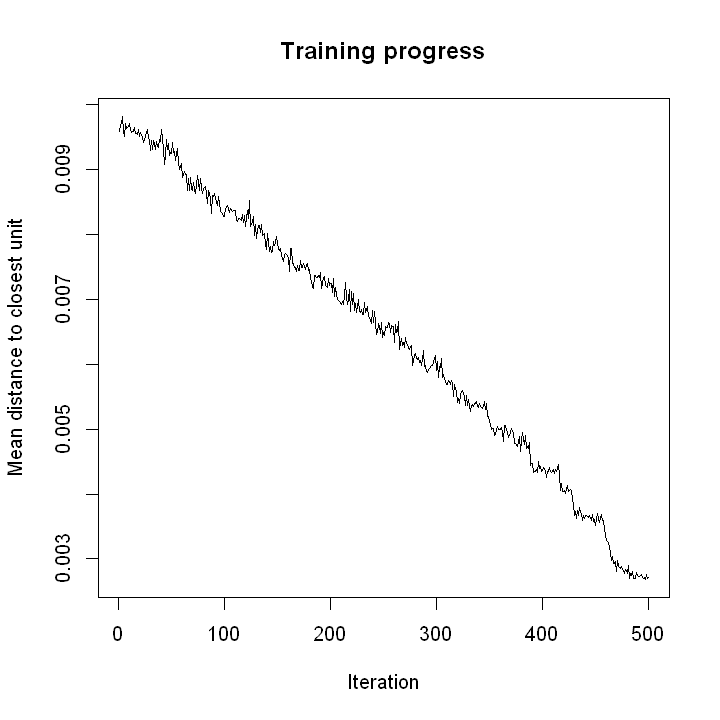

In [32]:
## custom palette as per kohonen package (not compulsory)
source('coolBlueHotRed.R')
plot(som_model, type = "changes")

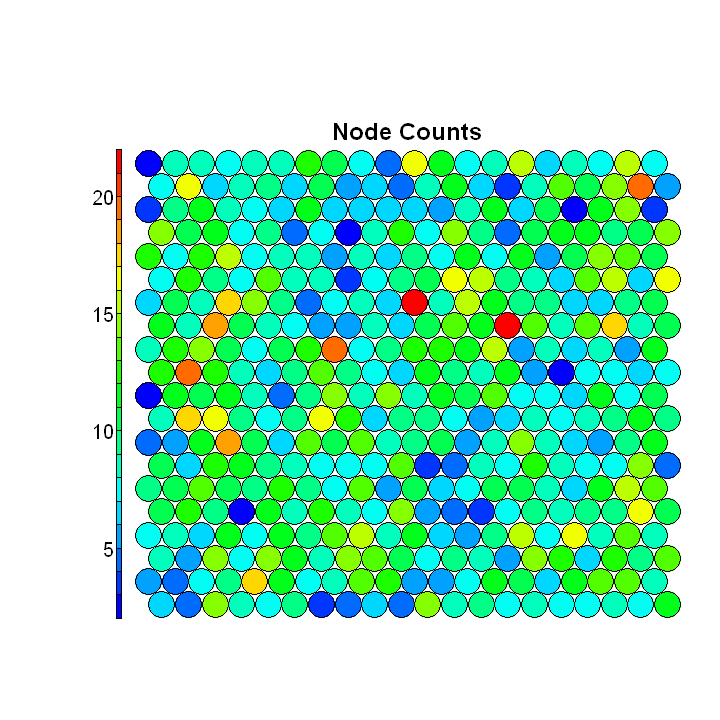

In [33]:
plot(som_model, type = "counts", main="Node Counts", palette.name=coolBlueHotRed)

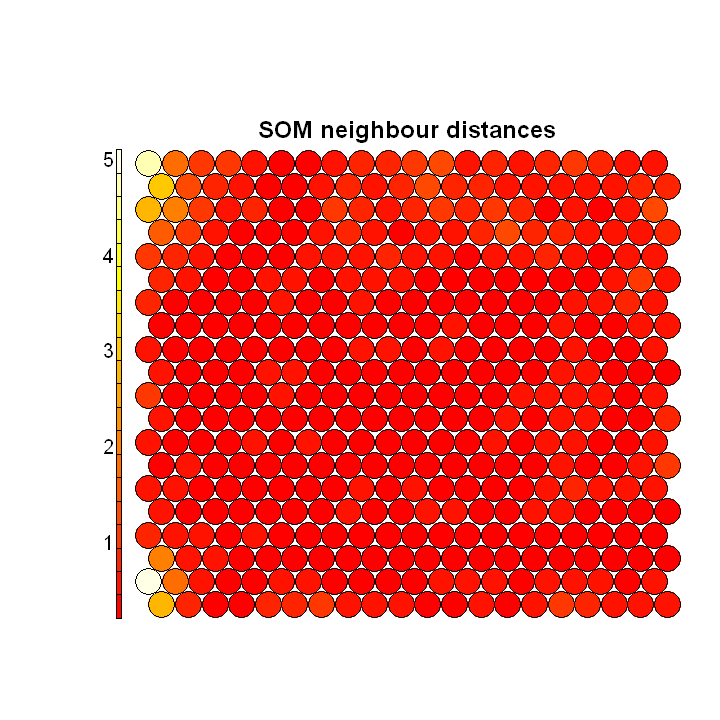

In [34]:
plot(som_model, type="dist.neighbours", main = "SOM neighbour distances")

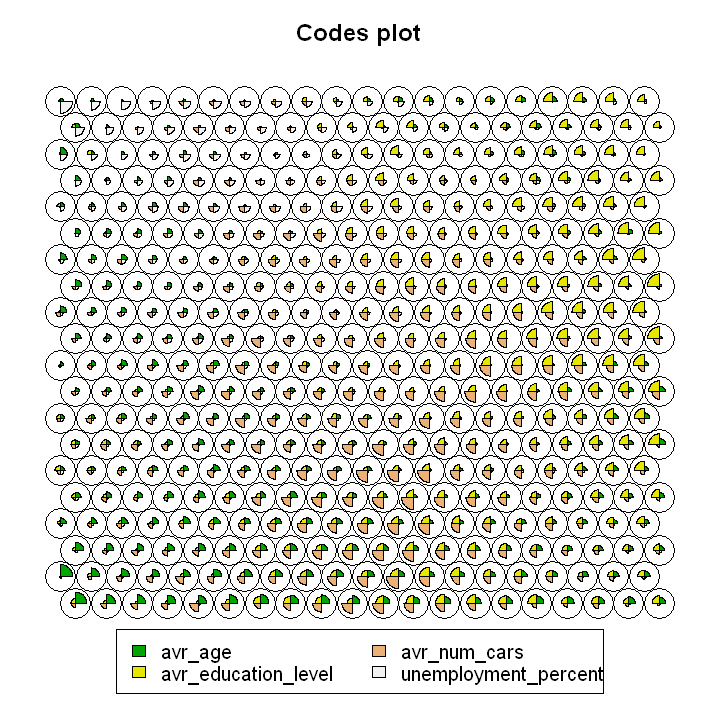

In [35]:
plot(som_model, type="codes")

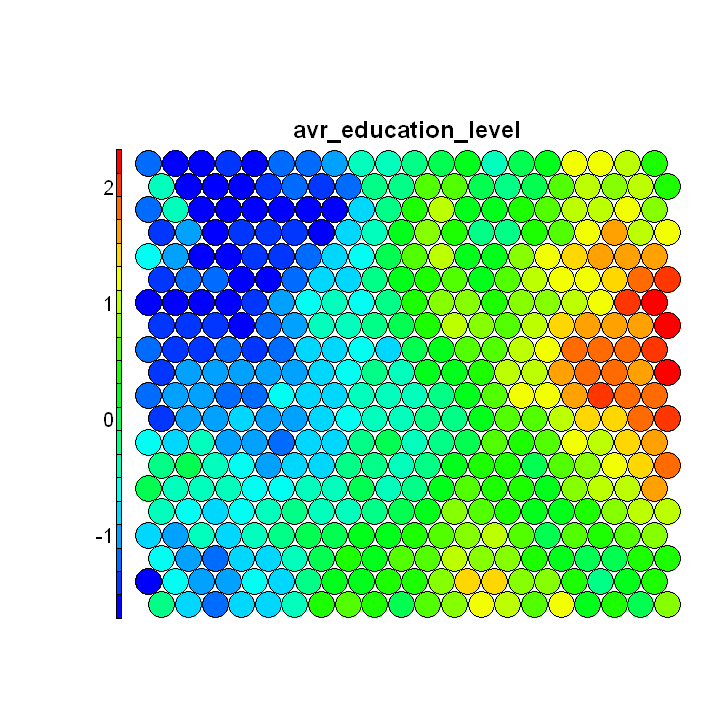

In [36]:
plot(som_model, type = "property", property = getCodes(som_model)[,2], main=colnames(getCodes(som_model))[2], palette.name=coolBlueHotRed)

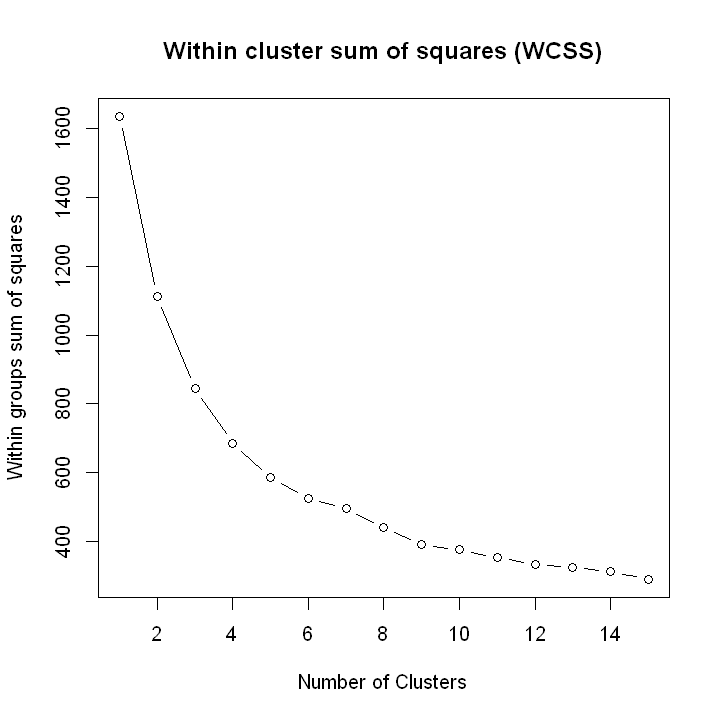

In [46]:
mydata <- getCodes(som_model)
wss <- (nrow(mydata)-1)*sum(apply(mydata,2,var))
for (i in 2:15) wss[i] <- sum(kmeans(mydata,
                                     centers=i)$withinss)
par(mar=c(5.1,4.1,4.1,2.1))
plot(1:15, wss, type="b", xlab="Number of Clusters",
     ylab="Within groups sum of squares", main="Within cluster sum of squares (WCSS)")